In [5]:
from visual_behavior import utilities as vbu
import visual_behavior.plotting as vbp
from visual_behavior.utilities import EyeTrackingData
from visual_behavior import database as db
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import seaborn as sns
import matplotlib.patches as patches

from scipy import stats

from multiprocessing import Pool

from dro.modules import eye_tracking as et
from dro.modules import plotting as plot_utils

from matplotlib import animation, rc

In [80]:
ed = EyeTrackingData(int(osid),data_source='filesystem')

here
eye
behavior


In [81]:
ed

In [83]:
osid = 913564409
ed = et.open_eye_data(osid)
bd = et.open_behavior_data(osid)

on osid = 913564409
on osid = 913564409


In [121]:
initial_time = 3504.5

In [122]:
def make_figure(ed,bd,time,fig,ax,t0,tf):
    
    colormap = {im:color for im,color in zip(bd.visual_stimuli.image_name.unique(),sns.color_palette("brg", 8))}
    
    for ii,key in enumerate(list(ax.keys())):
        ax[key].cla()
    ax['annotated_frame'].imshow(ed.get_annotated_frame(time=time,pupil=True,eye=False))
    ax['annotated_frame'].axis('off')
    
    ax['unannotated_frame'].imshow(ed.get_annotated_frame(time=time,pupil=False,eye=False))
    ax['unannotated_frame'].axis('off')
    
    behavior_movie = vbu.Movie(ed.behavior_movie_path,sync_timestamps=ed.sync_timestamps['behavior'])
    ax['behavior'].imshow(behavior_movie.get_frame(time=time))
    ax['behavior'].axis('off')
    
    df = ed.ellipse_fits['pupil'].set_index('time')
    ax['ts'].plot(df.loc[t0-2:tf+1].index,df.loc[t0-2:tf+1]['blink_corrected_area'])
    
    ax['ts'].set_ylim(3500,9500)
    ax['ts'].set_ylabel('pupil diameter (px**2)')
    ax['ts'].set_xlabel('time in session (s)')
    
    for idx,row in bd.visual_stimuli.set_index('time').loc[t0:tf].iterrows():
        ax['ts'].axvspan(idx,idx+0.25,color=colormap[row['image_name']],alpha=0.25,zorder=-np.inf)
    ax['ts'].axvline(time,color='black',linewidth=2)
    
    ax['ts'].set_xlim(t0,tf)
    
def update(frame):
    # check if animation is at the last frame, and if so, stop the animation a
    if frame >= 12: 
        a.event_source.stop()
    
    current_time = times_to_show[frame]
    print('current_time = {:.3f} of {:.3f}'.format(current_time,times_to_show[:N].max()),end='\r')

    make_figure(ed,bd,time=current_time,fig=fig,ax=ax,t0=t0,tf=tf)

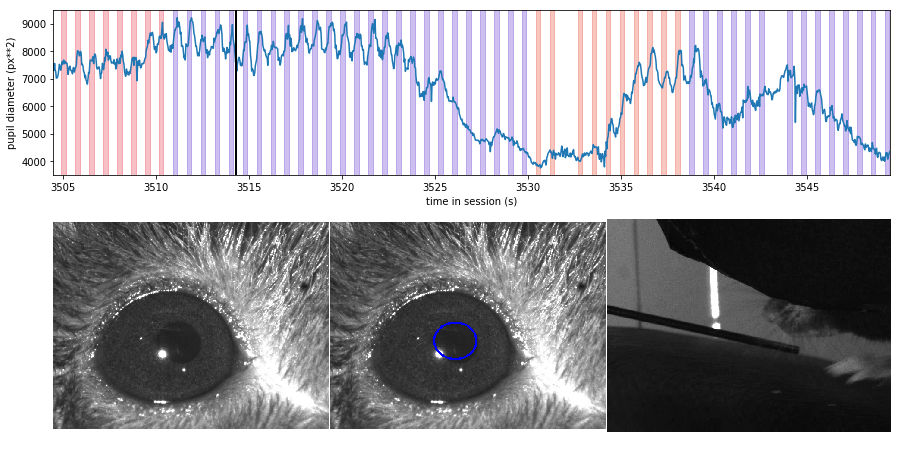

In [124]:
fig = plt.figure(figsize=(15,8))
ax = {}
ax['ts'] = vbp.placeAxesOnGrid(fig,xspan=[0,1],yspan=[0,0.38])
ax['unannotated_frame'] = vbp.placeAxesOnGrid(fig,xspan=[0,0.33],yspan=[0.45,1])
ax['annotated_frame'] = vbp.placeAxesOnGrid(fig,xspan=[0.33,0.6667],yspan=[0.45,1])
ax['behavior'] = vbp.placeAxesOnGrid(fig,xspan=[0.6667,1],yspan=[0.45,1])

t0 = initial_time
tf = initial_time+45
make_figure(ed,bd,time=t0+9.8,fig=fig,ax=ax,t0=t0,tf=tf)

In [125]:
framerate = 30 #hz
times_to_show = np.arange(t0,tf,1./framerate)

mpl.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
writer = animation.FFMpegFileWriter(fps=30, codec='mpeg4', bitrate=-1, extra_args=['-pix_fmt', 'yuv420p', '-q:v', '5'])

N = len(times_to_show)
a = animation.FuncAnimation(fig, update, frames=N, interval=1/framerate*1000,repeat=False,blit=False)
a.save('/tmp/single_pupil_example_osid={}_t0={}.mp4'.format(osid,initial_time), writer=writer)